# Characterize meta clusters (ie, groups of clusters that share characteristics)

This approach uses the model parameters: lengthscale, and mean function

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2

In [2]:
import joblib
from analysis_utils import *
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats




# Formatting params
sns.set(font_scale=2)
sns.set_style("white")

# col_palette = ['#176D9C', '#DBA137','#86AF49' ,'#df473c','#ae3c60', '#82b4bb', '#176D9C', '#DBA137','#86AF49' ,'#df473c','#ae3c60', '#82b4bb']
col_palette = ['#176D9C', '#DBA137','#86AF49' ,'#ae3c60', '#82b4bb', '#df473c', '#176D9C', '#DBA137','#86AF49' ,'#df473c','#ae3c60', '#82b4bb']

parameters = {'axes.labelsize': 25,
              'xtick.labelsize':15,
              'ytick.labelsize':25,
             'legend.fontsize':25,
              'legend.loc':'upper right',
              'xtick.labelsize':25,
              'ytick.labelsize':25,
             'pdf.fonttype':42, 
             'ps.fonttype':42, 
             'font.family':'arial'}
plt.rcParams.update(parameters)

In [3]:
refmod = joblib.load('../example/mogp_reference_model.pkl')
refdata = joblib.load('data/model_data/1_alsfrsr_all/data_proact_min3_alsfrst.pkl')

In [4]:
csum = summ_cluster_params(refmod, refdata)

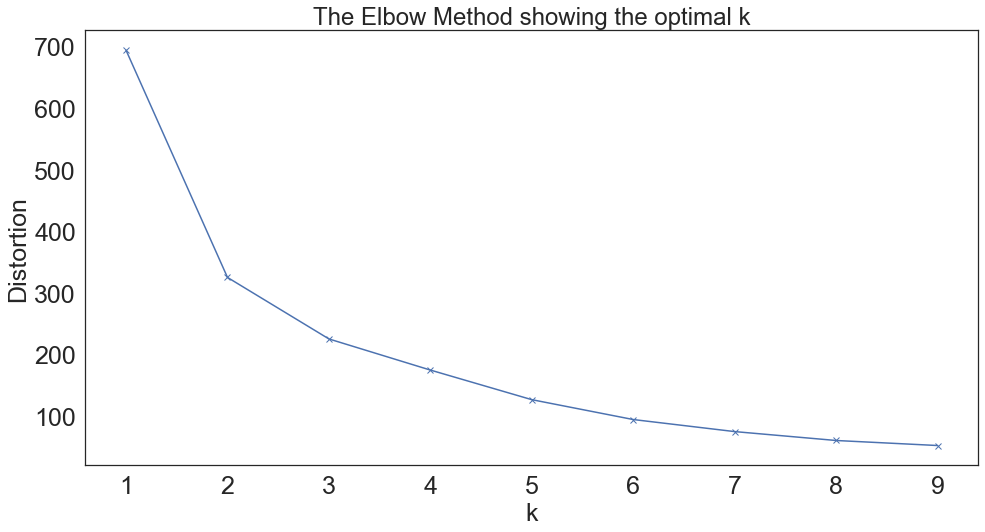

In [5]:
elbow_k(csum[['neg_linmap.A', 'rbf.lengthscale']])

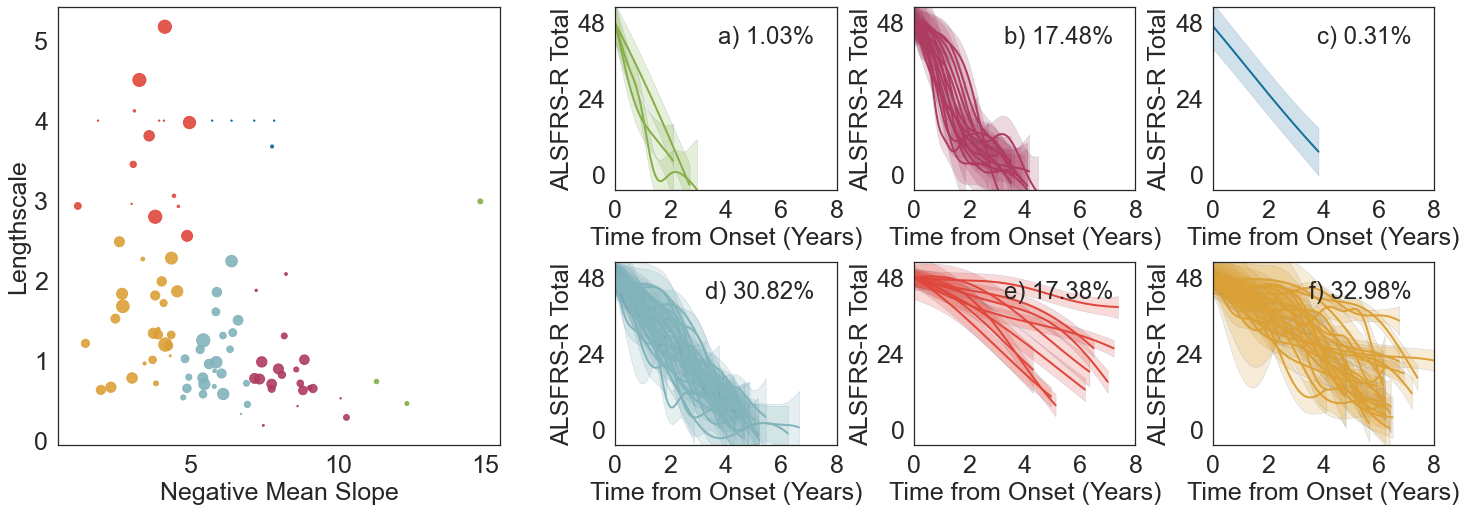

In [6]:
csum_k, cf,  kfig, _, _ = plot_k_clust(refmod, csum, num_clusters_set=6, clust_thresh_size=5, col_palette=col_palette)

In [7]:
csum_k.to_csv('reports/addl_table_kclust_5_mogp_refmod.csv')

In [8]:
kfig.savefig('reports/supp_fig_metaclusters.pdf', bbox_inches='tight')

## Check enrichment of cluster sets with clinical features

In [9]:
df_clin = pd.read_csv('data/processed_data/pat_clin_summ_stats.csv')
df_clin.rename(columns={'si_ind':'SI'}, inplace=True)
df_clin['hxli'] = df_clin['hxli'].fillna(0)
df_clin['hxblb'] = df_clin['hxblb'].fillna(0)

df_e = pd.DataFrame(zip(refmod.z, refdata['SI'],), columns=['clust', 'SI'])
df_e = df_e.merge(csum.reset_index()[['clust','kalph', 'clust_size']], on='clust')
df_e = df_e.merge(df_clin, on='SI', how='left')

df_e_format = pd.DataFrame()
df_e_format['Median Age of Onset'] = round(df_e.groupby('kalph')['age_onset'].median(),2)

limbsum = check_clust_freq(df_e, feat='hxli', ptid='SI', clustid='kalph')
limbsum.rename(columns={'1.0_freq':'Limb Frequency'}, inplace=True)
limbsum.rename(columns={'1.0_pval':'Limb P-Val'}, inplace=True)

bulbsum = check_clust_freq(df_e, feat='hxblb', ptid='SI', clustid='kalph')
bulbsum.rename(columns={'1.0_freq':'Bulbar Frequency'}, inplace=True)
bulbsum.rename(columns={'1.0_pval':'Bulbar P-Val'}, inplace=True)

limbsum['Limb Frequency']=['{:.2f}% ({})'.format(i[0]*100, i[1]) for i in zip(limbsum["Limb Frequency"],limbsum[1.0])]
bulbsum['Bulbar Frequency']=['{:.2f}% ({})'.format(i[0]*100, i[1]) for i in zip(bulbsum["Bulbar Frequency"],bulbsum[1.0])]

limbsum['Limb P-Val']=['{:.2e}'.format(i) for i in limbsum['Limb P-Val']]
bulbsum['Bulbar P-Val']=['{:.2e}'.format(i) for i in bulbsum['Bulbar P-Val']]

df_e_format = df_e_format.join(limbsum[['Limb Frequency', 'Limb P-Val']])
df_e_format = df_e_format.join(bulbsum[['Bulbar Frequency', 'Bulbar P-Val']])


In [10]:
df_e_format
df_e_format.to_csv('reports/supp_table_proact_metaclust_stats.csv')

,Median Age of Onset,Limb Frequency,Limb P-Val,Bulbar Frequency,Bulbar P-Val
kalph,,,,,
a,59.09,66.67% (20),1.50e-01,13.33% (4),1.30e-01
b,57.18,58.51% (299),4.63e-08,30.14% (154),8.73e-10
c,58.45,55.56% (5),1.88e-01,22.22% (2),3.03e-01
d,54.88,65.48% (590),2.41e-03,20.64% (186),3.59e-02
e,54.16,76.97% (391),9.28e-07,14.37% (73),5.95e-05
f,54.17,72.20% (696),3.07e-04,17.63% (170),2.26e-03
